In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

from google.colab import drive

drive.mount('/content/drive')

import numpy as np
from os import listdir

import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils.data import Dataset, DataLoader

class FullDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        # Exclude columns from the dataset
        df = df.drop(columns=['name', 'city', 'description', 'image', 'images', 'categoryReviews', 'userReviews'])
        
        # Remove '[' and ']' from 'Dominate' and 'Color' columns
        df['Dominate'] = df['Dominate'].str.replace(r'\[|\]', '', regex=True)
        df['Color'] = df['Color'].str.replace(r'\[|\]', '', regex=True)
        print(df['Dominate'])
        df = df.dropna()
        df[['Dominate_1', 'Dominate_2', 'Dominate_3']] = df['Dominate'].str.split(expand=True).astype(float)
        df[['Color_1', 'Color_2', 'Color_3']] = df['Color'].str.split(expand=True).astype(float)

        # Drop the original 'Dominate' and 'Color' columns
        df = df.drop(columns=['Dominate', 'Color'])
        df = df.dropna()

        self.features = df.drop(columns=['price'])
        
        # def expand_list_to_columns(a, column):
        #   expanded = a[column].apply(pd.Series)
        #   expanded.columns = [f'{column}_{i+1}' for i in range(expanded.shape[1])]
        #   a = pd.concat([a, expanded], axis=1)
        #   a = a.drop(columns=[column])
        #   return a
        
        # self.features = expand_list_to_columns(self.features, 'Dominate')
        # self.features = expand_list_to_columns(self.features, 'Color')

        # print(self.features['Color_1'])
        # print(self.features['Dominate_1'])
        self.labels = df['price']

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        x = torch.tensor(self.features.iloc[index].values, dtype=torch.float32)
        y = torch.tensor(self.labels.iloc[index], dtype=torch.float32)

        return x, y

class FullModel(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(FullModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, output_size)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = torch.relu(self.fc1(x))

        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [ ]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import random

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

csv_file = "/content/drive/MyDrive/Copy of final_data_plus_features.csv"

batch_size = 64
hidden_sizes = [256, 128, 64]
output_size = 1  # Assuming 'price' is a single-value label
num_epochs = 20
learning_rate = 0.001
weight_decay=1e-5

# Load and split the dataset
dataset = FullDataset(csv_file)
train_data, val_data = train_test_split(dataset, test_size=0.2)
val_data, test_data = train_test_split(val_data, test_size=0.5)

input_size = dataset[0][0].size(0)
print(dataset[0][0].size(0))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model = FullModel(input_size, *hidden_sizes, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, num_epochs, train_loss, val_loss))

# Test
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    print("Test Loss: {:.4f}".format(test_loss))

0          200.57826 200.7613  203.15504
1          19.295359 15.373721 14.762594
2          170.05089 169.21521 166.77252
3          183.58603 179.1546  161.714  
4       110.95356   77.24888   60.295742
                      ...               
2983       174.98586 170.27669 169.48189
2984       44.07484  38.75437  35.979973
2985          95.89696 88.01665 77.69004
2986       79.61572  74.024315 64.25743 
2987                                 NaN
Name: Dominate, Length: 2988, dtype: object
3649


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Epoch [1/20], Train Loss: 1.5501, Val Loss: 0.4451
Epoch [2/20], Train Loss: 0.4570, Val Loss: 0.4429
Epoch [3/20], Train Loss: 0.4401, Val Loss: 0.4305
Epoch [4/20], Train Loss: 0.4544, Val Loss: 0.5046
Epoch [5/20], Train Loss: 0.4320, Val Loss: 0.3996
Epoch [6/20], Train Loss: 0.4181, Val Loss: 0.4273
Epoch [7/20], Train Loss: 0.4042, Val Loss: 0.3937
Epoch [8/20], Train Loss: 0.4002, Val Loss: 0.3673
Epoch [9/20], Train Loss: 0.4211, Val Loss: 0.4005
Epoch [10/20], Train Loss: 0.4508, Val Loss: 0.3663
Epoch [11/20], Train Loss: 0.3942, Val Loss: 0.3592
Epoch [12/20], Train Loss: 0.4014, Val Loss: 0.3608
Epoch [13/20], Train Loss: 0.4135, Val Loss: 0.4000
Epoch [14/20], Train Loss: 0.5054, Val Loss: 0.3747
Epoch [15/20], Train Loss: 0.4101, Val Loss: 0.3578
Epoch [16/20], Train Loss: 0.3910, Val Loss: 0.4185
Epoch [17/20], Train Loss: 0.3996, Val Loss: 0.4016
Epoch [18/20], Train Loss: 0.3868, Val Loss: 0.3647
Epoch [19/20], Train Loss: 0.3988, Val Loss: 0.3590
Epoch [20/20], Train 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


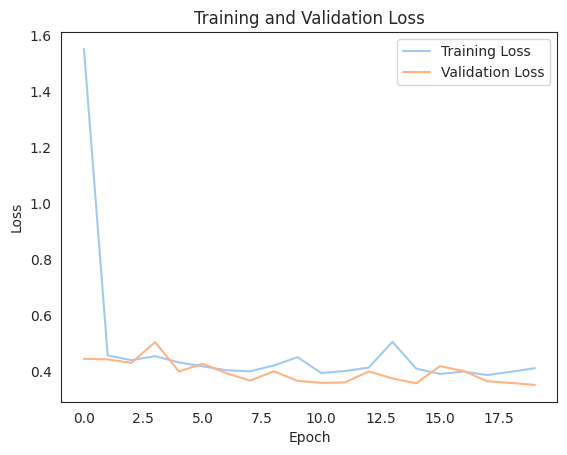

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

0.005062783180260766


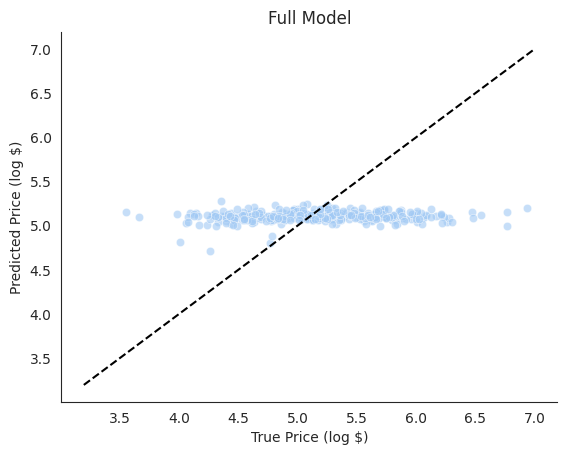

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

predictions = []
targets = []
model.eval()

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_dataloader):
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        targets.append(labels.numpy())

predictions = np.concatenate(predictions, axis=0)
y_test = np.array(targets)

predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1)
# print(predictions)

# print(y_test)
# plot the data
sns.set_style("white")
sns.set_palette("pastel")
print(r2_score(y_test, predictions))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Full Model")
sns.despine()
plt.savefig("full_model.png", dpi=200)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

predictions = []
targets = []
model.eval()

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        targets.append(labels.numpy())

predictions = np.concatenate(predictions, axis=0)
y_test = np.array(targets)

predictions = predictions.flatten()
y_test = y_test.flatten()
print(predictions)

print(y_test)
# plot the data
sns.set_style("white")
sns.set_palette("pastel")
print(r2_score(y_test, predictions))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Full Model on Train Set")
sns.despine()
plt.savefig("full_model.png", dpi=200)
plt.show()

[5.173132  5.220612  5.117376  ... 5.090819  5.1328998 5.0946026]
[array([5.1119876, 5.056246 , 5.8141303, 5.198497 , 5.7776523, 5.332719 ,
        4.6151204, 4.9416423, 5.2257466, 5.857933 , 3.9512436, 5.6801724,
        4.356709 , 4.574711 , 5.620401 , 5.0172796, 4.1271343, 4.7095304,
        5.1298985, 4.2195077, 6.395262 , 4.624973 , 4.3694477, 4.691348 ,
        4.7004805, 4.934474 , 5.164786 , 5.613128 , 5.0039463, 5.081404 ,
        4.8441873, 4.4188404, 4.75359  , 5.123964 , 4.8598123, 4.9767337,
        5.273    , 4.744932 , 5.030438 , 5.9107966, 5.811141 , 5.241747 ,
        6.1092477, 5.2040067, 5.293305 , 5.811141 , 4.9972124, 4.0253515,
        4.8751974, 5.1059456, 3.3672957, 4.189655 , 6.4441314, 4.2341065,
        4.204693 , 4.574711 , 4.7791233, 5.749393 , 4.7791233, 5.9322453,
        4.9416423, 4.89784  , 5.117994 , 4.644391 ], dtype=float32)
 array([5.3471074, 4.8598123, 4.8520303, 4.8751974, 5.241747 , 4.553877 ,
        6.016157 , 4.644391 , 5.869297 , 6.154858 , 

<ipython-input-51-0525710d71d8>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_test = np.array(targets)


ValueError: ignored